In [1]:
import numpy as np
import pandas as pd
import os
import skimage
from skimage import io
from skimage import img_as_float
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.metrics import roc_auc_score, f1_score
from os import listdir
from skimage import io, transform, util, img_as_float
from tqdm import tqdm_notebook
from keras_tqdm import TQDMNotebookCallback
from fastnumbers import fast_real
from keras import Sequential
from keras import models
from keras.layers.core import Activation, Reshape, Permute
from keras.layers import Conv2D, Flatten, Dropout, Dense, MaxPooling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from tqdm import tqdm
%matplotlib inline

/home/ivan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def txt2arr (path):
    yLinesCoords = []
    f = open(path, 'r', encoding='utf-16')
    line = f.readline()
    while line:
        line = f.readline()
        if line.split("	")[0] != "" :
            num1 = line.split("	")[0]
            num2 = line.split("	")[1].split("\n")[0]
            yLinesCoords.append(fast_real(num1))
            yLinesCoords.append(fast_real(num2))
    f.close()
    
    res = np.zeros(h)
    i = 0
    while i < len(yLinesCoords)/2:
        j = yLinesCoords[2*i]
        while j < yLinesCoords[2*i + 1]:
            res[j]= 1
            j += 1
        i += 1   
    return res

In [3]:
def shapeA4 (img):
    padded_img = np.zeros((3508, 2480))
    padded_img[:img.shape[0], :img.shape[1]] = img
    return padded_img

In [4]:
n_train_samples = 100
n_test_samples = 20
n_labels = 2
kernel_first = 5
kernel_second = 7
h = 1754#3508#1760 #3520 #3508
w = 1240#2480#1248 #2496 #2480

In [ ]:
for i, filename in tqdm(enumerate(os.listdir('train_img/')[:n_train_samples])):
    onlyName = filename.split('.')[0]
    img = skimage.io.imread('train_img/' + filename)
    x_arr = img / 255.0
    y_arr = txt2arr('train_txt/' + onlyName + '.txt')   
    
    x_arr_1 = x_arr[0:1754, 0:1240]
    y_arr_1 = y_arr[0:1754]
    x_arr_2 = x_arr[0:1754, 1240:2480]
    y_arr_2 = y_arr[0:1754]
    x_arr_3 = x_arr[1754:3508, 0:1240]
    y_arr_3 = y_arr[1754:3508]
    x_arr_4 = x_arr[1754:3508, 1240:2480]
    y_arr_4 = y_arr[1754:3508]
    
    np.savez_compressed('saved/train/' + onlyName + '_1.npz', x=x_arr_1, y=y_arr_1) 
    np.savez_compressed('saved/train/' + onlyName + '_2.npz', x=x_arr_2, y=y_arr_2) 
    np.savez_compressed('saved/train/' + onlyName + '_3.npz', x=x_arr_3, y=y_arr_3) 
    np.savez_compressed('saved/train/' + onlyName + '_4.npz', x=x_arr_4, y=y_arr_4) 

In [ ]:
for i, filename in tqdm(enumerate(os.listdir('test_img/')[:n_test_samples])):
    onlyName = filename.split('.')[0]
    img = skimage.io.imread('test_img/' + filename)
    x_arr = img / 255.0
    y_arr = txt2arr('test_txt/' + onlyName + '.txt')
    
    x_arr_1 = x_arr[0:1754, 0:1240]
    y_arr_1 = y_arr[0:1754]
    x_arr_2 = x_arr[0:1754, 1240:2480]
    y_arr_2 = y_arr[0:1754]
    x_arr_3 = x_arr[1754:3508, 0:1240]
    y_arr_3 = y_arr[1754:3508]
    x_arr_4 = x_arr[1754:3508, 1240:2480]
    y_arr_4 = y_arr[1754:3508]
    
    np.savez_compressed('saved/test/' + onlyName + '_1.npz', x=x_arr_1, y=y_arr_1) 
    np.savez_compressed('saved/test/' + onlyName + '_2.npz', x=x_arr_2, y=y_arr_2) 
    np.savez_compressed('saved/test/' + onlyName + '_3.npz', x=x_arr_3, y=y_arr_3) 
    np.savez_compressed('saved/test/' + onlyName + '_4.npz', x=x_arr_4, y=y_arr_4) 

In [5]:
def img_generator(directory, batch_size):
    filenames = os.listdir(directory)
    while True:
        n_iter = len(filenames) // batch_size
        residual = len(filenames) % batch_size
        for i in range(n_iter):
            size = batch_size
            if (i == n_iter - 1) and (residual > 0):
                size = residual
            X = np.zeros((batch_size, h, w, 1))
            y = np.zeros((batch_size, h))
            for j in range(size):
                X[j] = np.load(directory + filenames[i * batch_size + j])['x'].reshape((h, w, 1))
                y[j] = np.load(directory + filenames[i * batch_size + j])['y']
            yield X, y

In [6]:
autoencoder = Sequential()
encoding_layers = [
    Convolution2D(8, kernel_first, kernel_first, border_mode='same', input_shape=( 1754, 1240, 1)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((4,4)),
#    
    Convolution2D(16, kernel_first, kernel_first, border_mode='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((3,3)),
#    
    Convolution2D(16, kernel_second, kernel_second, border_mode='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
#  
    Convolution2D(16, kernel_first, kernel_first, border_mode='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
#    
    Convolution2D(4, kernel_first, kernel_first, border_mode='same'),
    BatchNormalization(),
    Activation('relu'),
]


for l in encoding_layers:
    autoencoder.add(l)
    #print(l.input_shape,l.output_shape,l)
autoencoder.add(Flatten())
autoencoder.add(Dense(1754, activation='sigmoid'))

/home/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (5, 5), input_shape=(1754, 124..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), padding="same")`
  
/home/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (7, 7), padding="same")`
  del sys.path[0]
/home/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), padding="same")`
/home/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (5, 5), padding="same")`


In [7]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1754, 1240, 8)     208       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1754, 1240, 8)     32        
_________________________________________________________________
activation_1 (Activation)    (None, 1754, 1240, 8)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 438, 310, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 438, 310, 16)      3216      
_________________________________________________________________
batch_normalization_2 (Batch (None, 438, 310, 16)      64        
_________________________________________________________________
activation_2 (Activation)    (None, 438, 310, 16)      0         
__________

In [8]:
train_generator = img_generator('saved/train/', 5)
test_generator = img_generator('saved/test/', 5)

autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
autoencoder.fit_generator(train_generator, steps_per_epoch=100//5, epochs=10, validation_data=test_generator, validation_steps=4)

Epoch 1/10
20/20 [==============================] - 327s 16s/step - loss: 6871.8926 - acc: 0.0000e+00 - val_loss: 6913.5885 - val_acc: 0.0000e+00
Epoch 2/10
20/20 [==============================] - 325s 16s/step - loss: 6760.7245 - acc: 0.0000e+00 - val_loss: 6906.2758 - val_acc: 0.0000e+00
Epoch 3/10
20/20 [==============================] - 337s 17s/step - loss: 6236.2217 - acc: 0.0000e+00 - val_loss: 6897.2635 - val_acc: 0.0000e+00
Epoch 4/10
20/20 [==============================] - 346s 17s/step - loss: 6712.0822 - acc: 0.0000e+00 - val_loss: 6892.3031 - val_acc: 0.0000e+00
Epoch 5/10
20/20 [==============================] - 381s 19s/step - loss: 6818.7756 - acc: 0.0000e+00 - val_loss: 6888.3483 - val_acc: 0.0000e+00
Epoch 6/10
20/20 [==============================] - 351s 18s/step - loss: 6436.8356 - acc: 0.0000e+00 - val_loss: 6899.1407 - val_acc: 0.0000e+00
Epoch 7/10
20/20 [==============================] - 351s 18s/step - loss: 6477.6091 - acc: 0.0000e+00 - val_loss: 6918.1482 

In [9]:
autoencoder.save('temp/model.h5')
#autoencoder = load_model('temp/model.h5')

In [14]:
filename = '662.jpg'
img = skimage.io.imread('test_img/' + filename)
normalized = img / 255.0
x_data = normalized[0:1754, 0:1240]
res = autoencoder.predict(x_data.reshape((1, h, w, 1)))


In [16]:
print (res.shape)

(1, 1754)


In [20]:
res = res.reshape((1754,))
print (res.shape)
print(len(res))

(1754,)
1754


In [69]:
lines = arr2lines(res)

In [70]:
print(lines)

[ 313  329  361  393  409  449  465  497  513  537  569  601  617  649
  665  705  721  753  769  809  825  857  873  913  929  961  977 1017
 1033 1065 1081 1129 1145 1169 1185 1233 1249 1273 1289 1321 1353 1377
 1393 1425 1441 1489 1505 1529 1545 1593 1609 1633 1649 1697 1713 1737]


In [68]:
def arr2lines(arr, delta = 8):
    size = len(arr)
    #фильтрация шума
    i = 0
    while (i+delta < size):
        sum = 0
        for k in range(delta):
            sum += arr[i+k]
        if (sum > delta/2):
            for k in range(delta):
                arr[i+k] = 1
        else:
            for k in range(delta):
                arr[i+k] = 0
        i+=delta
    while i<size:
        arr[i] = 0 
        i+=1
        
    #нахождение строк
    listLines = []
    i = 1
    prev = arr[0]
    cur = arr[1]
    while i < size:
        if prev != cur:
            listLines.append(i)
        prev = cur
        cur = arr[i]
        i+=1
    res = np.array(listLines)
    return res

In [ ]:
def vizual4arr (arr, width = 50):
    

In [59]:
A = np.array([1,2,3])
B = np.array([2,3,4])
result = np.abs(A-B).mean
print (result)

<built-in method mean of numpy.ndarray object at 0x7fbe98505710>


In [49]:
def getLinesFromFile (path):
    data = []
    f = open(path, 'r', encoding='utf-16')
    line = f.readline()
    while line:
        line = f.readline()
        if line.split("	")[0] != "" :
            num1 = line.split("	")[0]
            num2 = line.split("	")[1].split("\n")[0]
            data.append(fast_real(num1))
            data.append(fast_real(num2))
    f.close()
    res = np.array(data)
    return res

In [54]:
origLines = getLinesFromFile('test_txt/662.txt')[0:56]
print(origLines)
print(len(origLines))

[ 313  336  355  391  407  443  460  495  512  547  563  600  615  651
  668  703  719  756  771  808  823  859  876  912  927  963  979 1015
 1031 1067 1083 1119 1135 1171 1186 1223 1239 1275 1291 1327 1343 1379
 1395 1431 1447 1483 1499 1535 1552 1587 1603 1640 1656 1691 1707 1743]
56


In [60]:
def getMeanArrDiff (A, B):
    size = min (len(A), len(B))
    absSum = 0
    for i in range(size):
        absSum += abs (A[i] - B[i])
    return absSum/size

In [61]:
print (getMeanArrDiff (origLines, lines))

3.8214285714285716


In [66]:
def getArrDiff (A, B):
    size = min (len(A), len(B))
    absRes = []
    for i in range(size):
        absRes.append(abs(A[i] - B[i]))
    res =np.array(absRes)
    return res

(array([ 1.,  5., 22.,  3.,  0.,  1., 14.,  4.,  0.,  6.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

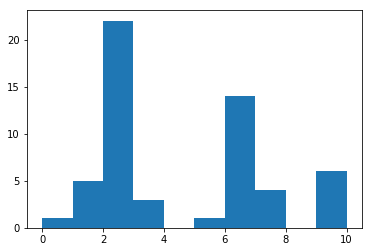

In [71]:
import matplotlib.pyplot as plt
plt.hist (getArrDiff(origLines, lines))